<a href="https://colab.research.google.com/github/JacopoKahl/vae_mnist/blob/main/Variational_Autoencoder_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Variatioal Autoencoder using the function API on MNIST dataset

Example of variational autoencoder on MNIST

**Warning! This notebook will make use of Tensorflow 1.x** 
since variational model can be problematic with TF 2.x

In [1]:
# Use previous version of TF

%tensorflow_version 1.x

TensorFlow 1.x selected.


#Imports

Import libraries and functions

In [2]:
#Keras imports
#from keras.models import Sequential #Sequential model class
from keras.models import Model #functional model for generic architectures
from keras.layers import Dense, Flatten, Conv2D, Conv2DTranspose, Reshape
from keras.layers import Input#input layer specific to functioinal API and specifies input dimensions
from keras.layers import Lambda # Lambda layer to model custom layer 

from keras.layers.advanced_activations import LeakyReLU #Leaky ReLU actiavation function layer

from keras.callbacks import ModelCheckpoint #import class for checkpointing the training process saving weights during progress
from keras.models import load_model #function for importing the whole model

import keras.backend as K #Import Tensorflow backend for low-level operations on tensors

import numpy as np #numerical library numpy

#Import dataset
from keras.datasets import mnist #hand-written digits dataset

#Visualization
import matplotlib.pyplot as plt #visualization library
from keras.utils.vis_utils  import plot_model   # plot_model is a function for model visualization

Using TensorFlow backend.


#Load dataset 

In [3]:
#load train and test data
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() 

11493376/11490434 [==============================] - 1s 0us/step


## Checking dataset...

In [4]:
print('Dimensioni input training set: ', X_train.shape)
print('Dimensioni output training set: ', Y_train.shape)

print('Dimensioni input test set: ', X_test.shape)
print('Dimensioni output test set: ', Y_test.shape)


Dimensioni input training set:  (60000, 28, 28)
Dimensioni output training set:  (60000,)
Dimensioni input test set:  (10000, 28, 28)
Dimensioni output test set:  (10000,)


Label:  5


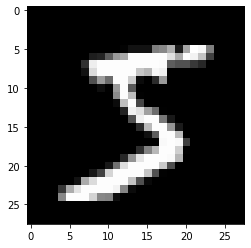

In [5]:
#Peeking into the training set...

index=0

plt.imshow(X_train[index], cmap='gray') #show input image at index with grayscale colormap since the images are single-channel!
print('Label: ', Y_train[index])

# Pre-processing the dataset

Normalizing and reshaping vectors

In [6]:
X_train = X_train.astype('float32') / 255  #casting to float and normalizing input in the [0,1] interval
X_test = X_test.astype('float32') / 255  #casting to float and normalizing input in the [0,1] interval

Reshaping input : creating two variables to holde dimensions info

In [7]:
#Forcing (#samples, width, height, #channels) dimensions with a reshape operation

train_dim = X_train.shape + (1,) # input dimensions by concatenating original dims with (1,)
test_dim = X_test.shape + (1,) # input dimensions by concatenating original dims with (1,)

print(train_dim)
print(test_dim)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [8]:
X_train = np.reshape(X_train, train_dim) # reshaping calling reshape function of the numpy library
X_test = np.reshape(X_test, test_dim) # reshaping calling reshape function of the numpy library

In [9]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#Autoencoder model

**Note on the functional model:**

The functional model requires the layers to be defined in a pipeline where each layer if connected to the preceding layer and the following one.

The network is then intended as a graph that can have arbitrary structure, not necessarily sequential.


## Network structure

In [10]:
inShape = X_train.shape[1:]
print ('Single input shape: ', inShape)

latent_dim = 2 #Latent space dimension: 2D is easy to visualize, for better reconstruction performance try 16 or greater...

imageDim = inShape[:2]

print('Image resolution: ', imageDim)

Single input shape:  (28, 28, 1)
Image resolution:  (28, 28)


## Encoder

Encoder network that creates representation in the latent space for input images.

The encoder architecture now splits in mu and logVar layers to merge again in the Lambda layer.

Please note that the logarithm of the variance is used for better performance with values that are close to 0. That is, sigma that might easily be in the interval $[0, \infty]$ will be mapped to the $[-\infty, \infty]$ interval.

The following equivalence will be exploited:

$\sigma = \exp(\log(\sigma)) =  \exp(2*\log(\sigma)/2)) =  \exp(\log(\sigma^2)/2)$

so we can model the logarithm of the variance instead of sigma directly.


**Note on the sampling function:**
the sampling function is coded to return 
$\mu + \epsilon*\sigma$

In [11]:
inputLayer = Input(shape=inShape, name='Encoder_input') #input layer
    
encoded = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(inputLayer)
encoded = LeakyReLU()(encoded) #Leaky ReLU activstion needs to be defined as separate layer

encoded = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(encoded)
encoded = LeakyReLU()(encoded) #Leaky ReLU activstion needs to be defined as separate layer

encoded = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(encoded)
encoded = LeakyReLU()(encoded) #Leaky ReLU activstion needs to be defined as separate layer

encoded = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(encoded)
encoded = LeakyReLU()(encoded) #Leaky ReLU activstion needs to be defined as separate layer

#encShapeBeforeFlatten = encoded.shape[1:].as_list() #save dimensions of output feature map before flattening
encShapeBeforeFlatten = K.int_shape(encoded)[1:]
print('Encoder output shape before flatten: ', encShapeBeforeFlatten)

encoded = Flatten()(encoded) #flatten 2D output from previous layer into a 1D array
#encoded = Dense(units=latent_dim)(encoded) 
#encoded is now the output of the main trunk of the encoder that will be taken as input to the following branches

#Now the model splits into mu and logVar layers
mu = Dense(units=latent_dim, name='mu')(encoded) #mu is the mean of the normal distribution that defines a given sample
logVar = Dense(units=latent_dim, name='LogVar')(encoded) #logVar defines the logarithm of the variance of the normal distribution

#print(K.shape(encoded))

def sampling(args):  #definition of the sampling function that gets args as input list of arguments
  mu, logVar = args #split args list into components input
  epsilon = K.random_normal(shape=K.shape(mu), mean=0. , stddev=1.) #epsilon is sampled from a normal distribution with mean=0 and std=1
  return mu + K.exp(logVar/2)*epsilon

encoderOutput = Lambda(sampling, name='Encoder_output')([mu, logVar]) #Lambda layer for sampling the normal distribution for the input image

encoder = Model(inputLayer, encoderOutput, name='Encoder') #create the encoder as instance of the Model clase. 
#Note how the functional model requires the endpoints of the pipeline to be defined 

encoder.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Encoder output shape before flatten:  (7, 7, 64)
Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         Encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 28, 28, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496   

## Visualize enoder model

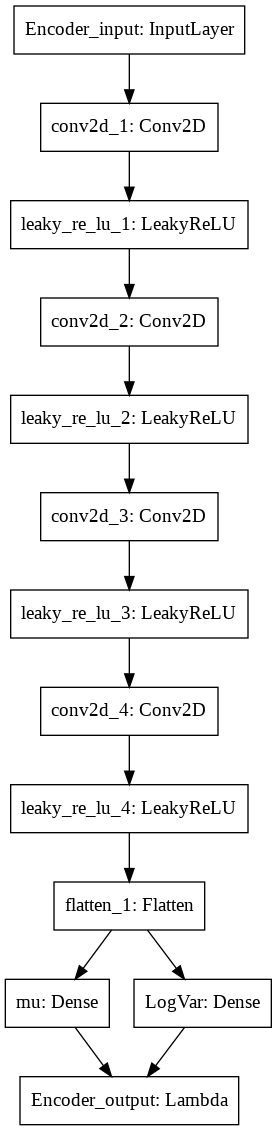

In [12]:
plot_model(encoder)

## Decoder

The decoder network reconstructs an image from vectors in the latent space. 

In [13]:
# Decoder with the function API

latentInput = Input(shape= (latent_dim,), name='Decoder_Input')

decoded = Dense(units = np.prod(encShapeBeforeFlatten), name = 'Decoder_FirstLayer')(latentInput)
decoded = Reshape(encShapeBeforeFlatten)(decoded)

decoded = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(decoded)
decoded = LeakyReLU()(decoded)

decoded = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(decoded)
decoded = LeakyReLU()(decoded)

decoded = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(decoded)
decoded = LeakyReLU()(decoded)

decoder_Output = Conv2DTranspose(filters=1, kernel_size=3, strides=1, activation= 'sigmoid', padding='same')(decoded)

decoder = Model(latentInput, decoder_Output, name='Decoder') #create the decoder as stand-alone model.

decoder.summary()

Model: "Decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input (InputLayer)   (None, 2)                 0         
_________________________________________________________________
Decoder_FirstLayer (Dense)   (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 14, 64)        0   

##Autoencoder

Compose di autoencoder by stacking together encoder and decoder

In [14]:
# autoencoder = Model(inputLayer, decoder_Output)  NO!! Graph disconnected! 

autoencoder = Model(inputLayer, decoder(encoder(inputLayer))) #connects together the encoder and the decoder 

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoder_input (InputLayer)   (None, 28, 28, 1)         0         
_________________________________________________________________
Encoder (Model)              (None, 2)                 105220    
_________________________________________________________________
Decoder (Model)              (None, 28, 28, 1)         102017    
Total params: 207,237
Trainable params: 207,237
Non-trainable params: 0
_________________________________________________________________


## Compile the autoencoder

Specify loss functions and optimizer.

The autoencoder now will work with two loss functions:

1.   Reconstruction loss (vae_r_loss): distance between input and output
2.   [Kullback-Lieber](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) loss (vae_kl_loss): distance between sample distribution and a normal distribution with mean=0 and std=1



In [15]:
#Reconstruction loss
def vae_r_loss(y_true, y_pred):
  r_loss = K.mean(K.square(y_true-y_pred), axis=[1,2,3]) #compute mse between input and output images 
  return  r_loss #*1000 #the reconstruction loss has a weighting factor

#KL loss
def vae_kl_loss(y_true, y_pred):
  kl_loss= -0.5 * K.sum(1 + logVar - K.square(mu) - K.exp(logVar), axis=1) #Compute the KL loss between P(mean=mu, std=sigma) e Q(mean=0, std=1)
  return kl_loss

#Combined loss
def vae_loss(y_true, y_pred): 
  r_loss = vae_r_loss(y_true, y_pred)
  kl_loss = vae_kl_loss(y_true, y_pred)
  return 1000*r_loss + kl_loss #the reconstruction loss has a weighting factor

In [16]:
autoencoder.compile(loss=vae_loss, optimizer='adam', metrics= [vae_r_loss, vae_kl_loss])

## Save model

The following instruction saves the whole model (the network architecture)

In [17]:
autoencoder.save('VAE.h5')

## Load weights

Optionally load weights from file

In [18]:
#autoencoder.load_weights('VAE_weights.h5')

#Training process

Attention! An autoencoder takes as output of the training function fit exactly the same dataset provided in input.

That is, the autoencoder has to learn to reproduce the input.

The learning process will make use of checkpoints to save progress.

In [19]:
#autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test))

#Note that checkpoints will be saved only for better weights (that reduce the loss)
checkpointer = ModelCheckpoint(filepath='VAE_weights.h5', verbose=1, save_best_only=True)

hist = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_data=(X_test, X_test), callbacks=[checkpointer])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 25s 424us/step - loss: 56.2740 - vae_r_loss: 0.0528 - vae_kl_loss: 3.4530 - val_loss: 51.9979 - val_vae_r_loss: 0.0483 - val_vae_kl_loss: 3.6955

Epoch 00001: val_loss improved from inf to 51.99787, saving model to VAE_weights.h5
Epoch 2/10
60000/60000 [==============================] - 19s 316us/step - loss: 50.9097 - vae_r_loss: 0.0467 - vae_kl_loss: 4.1823 - val_loss: 50.3926 - val_vae_r_loss: 0.0458 - val_vae_kl_loss: 4.6143

Epoch 00002: val_loss improved from 51.99787 to 50.39260, saving model to VAE_weights.h5
Epoch 3/10
60000/60000 [==============================] - 19s 315us/step - loss: 49.6121 - vae_r_loss: 0.0452 - vae_kl_loss: 4.4308 - val_loss: 48.7372 - val_vae_r_loss: 0.0442 - val_vae_kl_loss: 4.5147

Epoch 00003: val_loss improved from 50.39260 to 48.73722, saving model to VAE_weights.h5
Epoch 4/10
60000/60000 [==============================] - 19s 316us/step - 

## Save weights outside the training process, if a checkpointer was not used...



In [ ]:
#autoencoder.save_weights('VAE_weights.h5')

# Visualization

In [ ]:
#Generate output images corresponding to test input images

decodedImages = autoencoder.predict(X_test)

print(decodedImages.shape)

(10000, 28, 28, 1)


In [ ]:
X_test[0].shape

(28, 28, 1)

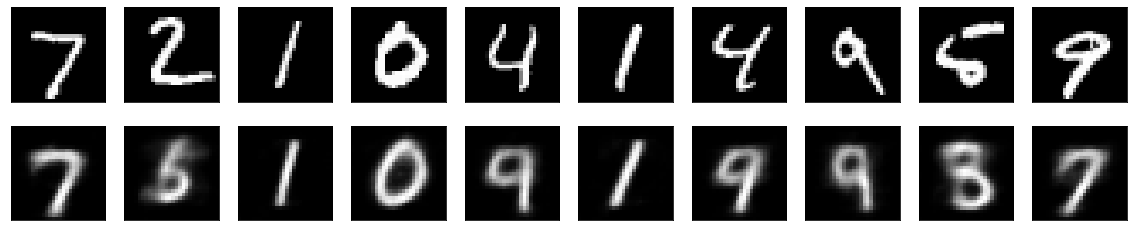

In [ ]:
#The following coder plots a figure made of 10 images per row on two rows

n = 10 #number of subfigures per row

plt.figure(figsize=(20,4)) # total figure size in inches

for i in range(n):     #for i in the rage [0,n) 
  #display original test images
  ax = plt.subplot(2, n, i+1) # create place-holder for i-th image (plt works with index starting with 1 not 0!)
  plt.imshow(X_test[i].reshape(28,28), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

  #display reconstructed test images
  ax = plt.subplot(2, n, i+1+n) # create place-holder for i-th image (plt works with index starting with 1 not 0!)
  plt.imshow(decodedImages[i].reshape(28,28), cmap='gray') #show i-th image
  ax.get_xaxis().set_visible(False) #disable x axis visibility
  ax.get_yaxis().set_visible(False) #disable y axis visibility

plt.show() # display entire image

## Show the latent space

Visualize the 2D vectors (points in a 2D space) generated by the encoder to represent training images.

In [ ]:
X_train_encoded = encoder.predict(X_train) #create encoded vectors (embeddings) for input images using only the encoder model

print(X_train_encoded.shape)

(60000, 2)


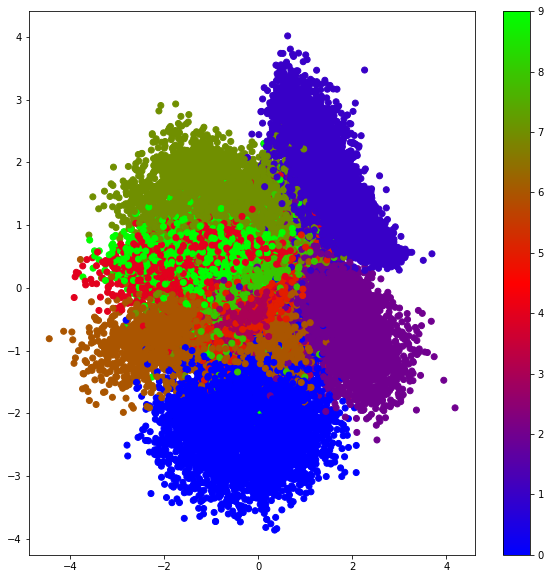

In [ ]:
plt.figure(figsize=(10,10)) #figure of 10x10 inches
plt.scatter(X_train_encoded[:, 0], X_train_encoded[:, 1], c=Y_train, cmap='brg') #scatter plot of the embeddings of the training images
plt.colorbar()
plt.show()

# Sampling from the latent space

Now we are justified to sample in the latent space from a clear distribution that governs the embeddings: a normal distribution centered in (0,0)

Sample vector:  [[-0.574746    0.78922683]]
Sample vector shape:  (1, 2)
Sample image shape:  (1, 28, 28, 1)


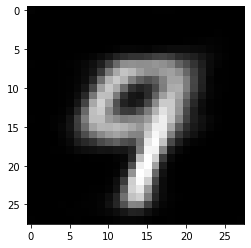

In [ ]:
#sample a new point from a normal distribution with parameters mu=(0,0) and sigma= 

sigma =2
sample_vec = np.random.normal(scale=sigma, size=(1, latent_dim)) #the new sample is a 2D vector 

print('Sample vector: ', sample_vec)
print('Sample vector shape: ', sample_vec.shape)


sample_img = decoder.predict(sample_vec)
print('Sample image shape: ', sample_img.shape)

plt.imshow(sample_img.reshape(imageDim), cmap='gray')


# Crossing the latent space...

Let's sample the latent space in the direction between two mean vectors (centers of clusters)  representing two different digits, for exmple 0 and 2.

## Vecor from label

The following function produces an embedding from a given digit label as the mean vector of the cluster

In [ ]:
label=0 #label of the digits whose indexes have to be extracted from the training set

#print(Y_train)

#Y_train== label

def vector_from_label(label):
  Y_train_indexes =  Y_train== label #Y_train_indexes is a boolean vector where True indicates the elements of Y_train that are equal to the label
  mean_vector = np.mean(X_train_encoded[Y_train_indexes], axis=0) #mean vector representing images of the cluster of vectors corresponding to the label

  return mean_vector

[-0.17763107 -1.9167812 ]


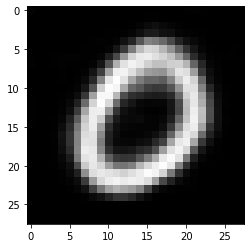

In [ ]:
zero = vector_from_label(0) #call function for label
print(zero)

img = decoder.predict(zero.reshape(((1,) + zero.shape)))

plt.imshow(img.reshape(imageDim), cmap='gray')

[ 1.4702226  -0.43957388]


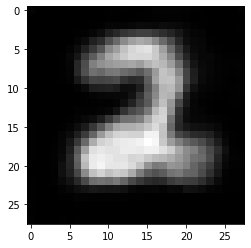

In [ ]:
two = vector_from_label(2) #call function for label

print(two)
img = decoder.predict(two.reshape(((1,) + two.shape)))

plt.imshow(img.reshape(imageDim), cmap='gray')

Let's now sample the latent space in the direction between two mean vectors representing different digits, for example 0 and 2.

$\alpha$ is a factor in $[0,1]$ determing the fraction odf the distance between the points (vectors), therefore the samping in that direction is computed as follows:

new_vector = $zero + \alpha*(two-zero)$

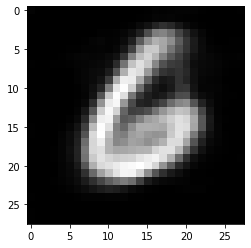

In [ ]:
alpha=0.5

new_vector = zero + alpha*(two-zero)

img= decoder.predict(np.reshape(new_vector, ((1,)+new_vector.shape)))

plt.imshow(img.reshape(imageDim), cmap='gray')

# Using Colab forms!

The following cell is identical to the previous one but makes use of a slider that is one of Colab forms components. The cell is also set to auto-run every time the slider is modified.

See:

https://colab.research.google.com/notebooks/forms.ipynb

0.06


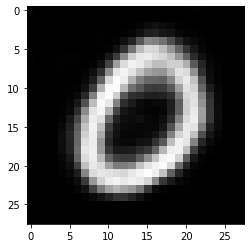

In [ ]:
# Auto-run cell with slider 
#@title Choose alpha value { run:'auto' }

alpha = 0.14 #@param {type:"slider", min:0, max:1, step:0.01}

print(alpha)

new_vector = zero + alpha*(two-zero)
img= decoder.predict(np.reshape(new_vector, ((1,)+new_vector.shape)))

plt.imshow(img.reshape(imageDim), cmap='gray')